In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold, LeaveOneGroupOut, train_test_split

In [2]:
SEED = 42
N_JOBS = -1

## Load data
with already extracted features in Features.ipynb

In [3]:
data = pd.read_csv("../data/data.csv")

X = data.drop(["timestamp", "label", "subject"], axis=1)
groups = data["subject"]
y = data["label"]

## Classifiers

In [4]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


def classify(split_name, X_train, y_train, X_test, y_test):
    classifiers_names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Gaussian Process",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "AdaBoost",
        "Naive Bayes",
        "Gradient Boosting",
    ]

    classifiers = [
        KNeighborsClassifier(n_neighbors=5, n_jobs=N_JOBS),
        SVC(kernel="linear", random_state=SEED),
        SVC(kernel="rbf", random_state=SEED),
        GaussianProcessClassifier(kernel=1.0 * RBF(1.0), n_jobs=N_JOBS, random_state=SEED),
        DecisionTreeClassifier(random_state=SEED),
        RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
        MLPClassifier(max_iter=1000, random_state=SEED),
        AdaBoostClassifier(random_state=SEED),
        GaussianNB(),
        GradientBoostingClassifier(random_state=SEED),
    ]

    df = pd.DataFrame(columns=["classifier", "split_method", "accuracy", "precision", "recall", "f1"])
    for name, clf in zip(classifiers_names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f_score, _ = precision_recall_fscore_support(
            y_test, y_pred, average="weighted", zero_division=0
        )
        df.loc[len(df)] = [name, split_name, acc, precision, recall, f_score]

    return df

# Train-Test Split
## Leave One Subject Out

In [5]:
logo = LeaveOneGroupOut()
logo_results = pd.DataFrame()
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    df = classify("logo", X_train, y_train, X_test, y_test)
    logo_results = pd.concat([logo_results, df], ignore_index=True)

logo_results = (
    logo_results.groupby(by=["classifier", "split_method"])
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)
logo_results

,classifier,split_method,accuracy,precision,recall,f1
5,Naive Bayes,logo,0.857772,0.876786,0.857772,0.851025
9,Random Forest,logo,0.815499,0.805924,0.815499,0.775871
3,Gradient Boosting,logo,0.677937,0.694913,0.677937,0.603737
0,AdaBoost,logo,0.649957,0.647620,0.649957,0.585396
1,Decision Tree,logo,0.616153,0.595051,0.616153,0.545461
7,Neural Net,logo,0.566718,0.541922,0.566718,0.484128
4,Linear SVM,logo,0.555074,0.587790,0.555074,0.460442
2,Gaussian Process,logo,0.469296,0.554557,0.469296,0.376937
6,Nearest Neighbors,logo,0.414227,0.381629,0.414227,0.340757
8,RBF SVM,logo,0.369743,0.364952,0.369743,0.307726


## 10-Fold

In [6]:
kf_10 = KFold(n_splits=10, shuffle=True, random_state=SEED)
kf_10_results = pd.DataFrame()
for train_index, test_index in kf_10.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    df = classify("10-fold", X_train, y_train, X_test, y_test)
    kf_10_results = pd.concat([kf_10_results, df], ignore_index=True)

kf_10_results = (
    kf_10_results.groupby(by=["classifier", "split_method"])
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)
kf_10_results

,classifier,split_method,accuracy,precision,recall,f1
1,Decision Tree,10-fold,0.981916,0.982466,0.981916,0.981934
3,Gradient Boosting,10-fold,0.976653,0.978005,0.976653,0.976646
9,Random Forest,10-fold,0.974089,0.975241,0.974089,0.974090
5,Naive Bayes,10-fold,0.968961,0.970145,0.968961,0.968995
7,Neural Net,10-fold,0.966262,0.967317,0.966262,0.965784
0,AdaBoost,10-fold,0.963765,0.965690,0.963765,0.962943
2,Gaussian Process,10-fold,0.961066,0.963702,0.961066,0.961157
6,Nearest Neighbors,10-fold,0.961066,0.964231,0.961066,0.961022
4,Linear SVM,10-fold,0.960864,0.962928,0.960864,0.960639
8,RBF SVM,10-fold,0.921930,0.932509,0.921930,0.920092


## Compare results

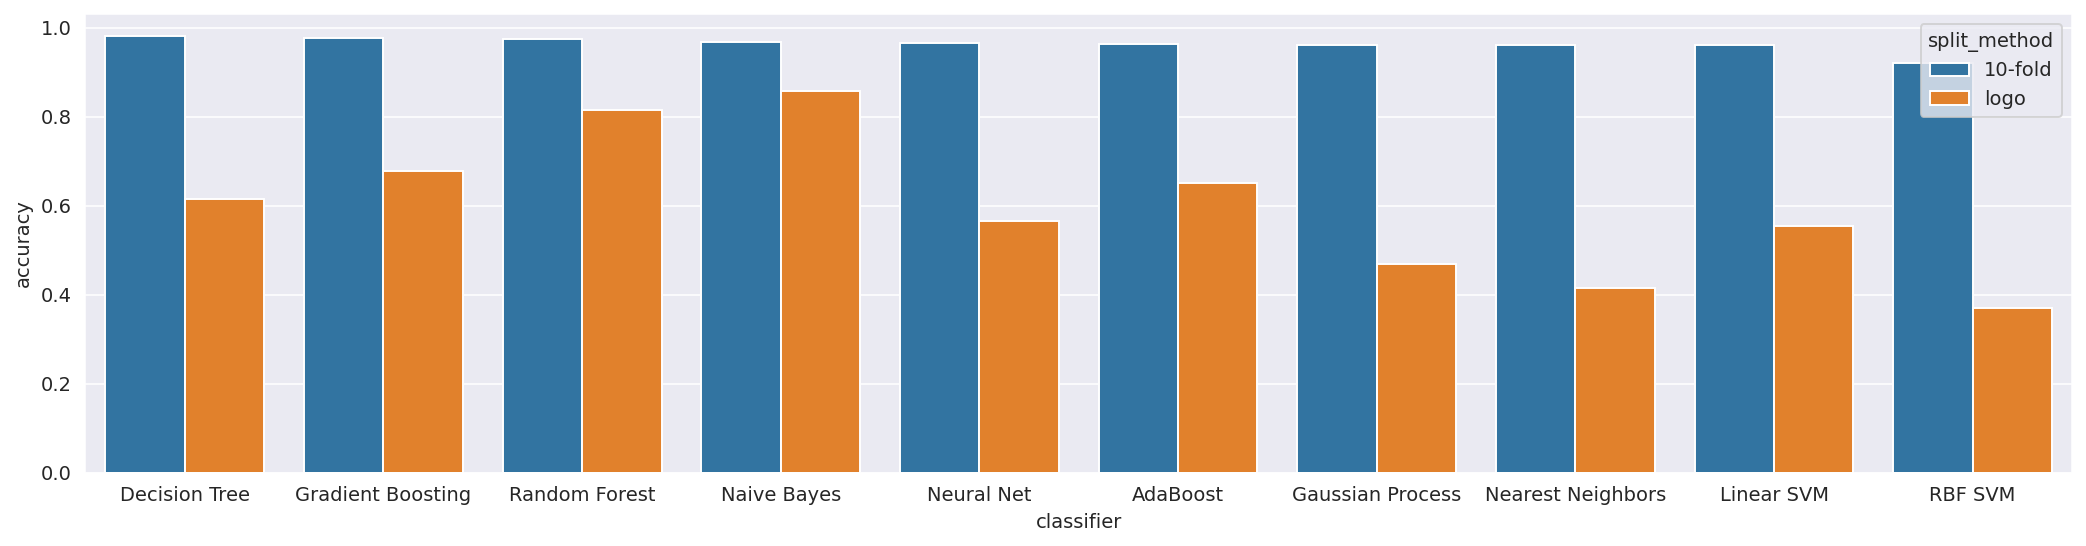

In [7]:
cv_results = pd.concat([kf_10_results, logo_results])
fig, ax = plt.subplots(figsize=(15, 4), dpi=140)
sns.barplot(x="classifier", y="accuracy", hue="split_method", data=cv_results, ax=ax)
fig.tight_layout()
plt.show()

## Observations
1. The 10-fold performs better than the LOSO for all tested classification algorithms.
2. The best classifier regarding 10-fold is a decision tree. So we choose a decision tree for our application.

# Feature Subset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED, stratify=y)

In [9]:
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))

Accuracy = 0.935064935064935


In [10]:
print("Tree depth =", clf.get_depth())

Tree depth = 4


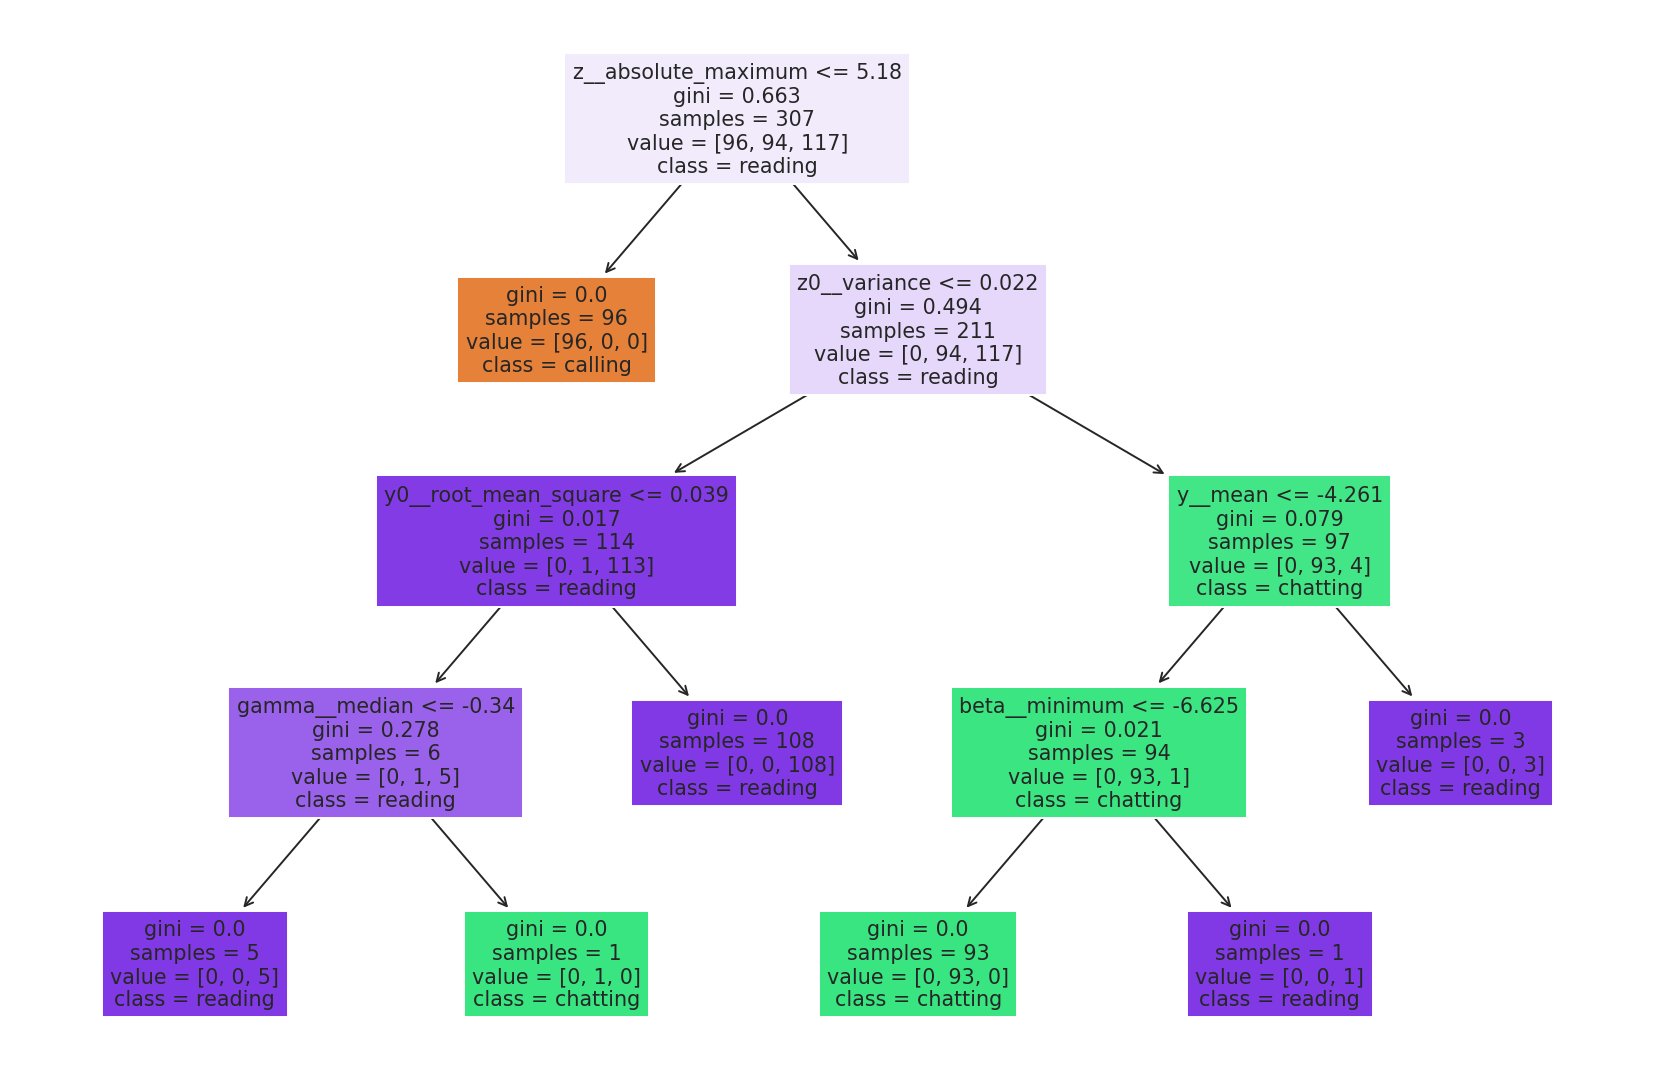

In [11]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=140)
_ = tree.plot_tree(
    clf, ax=ax, feature_names=X_train.columns, class_names=["calling", "chatting", "reading"], filled=True
)

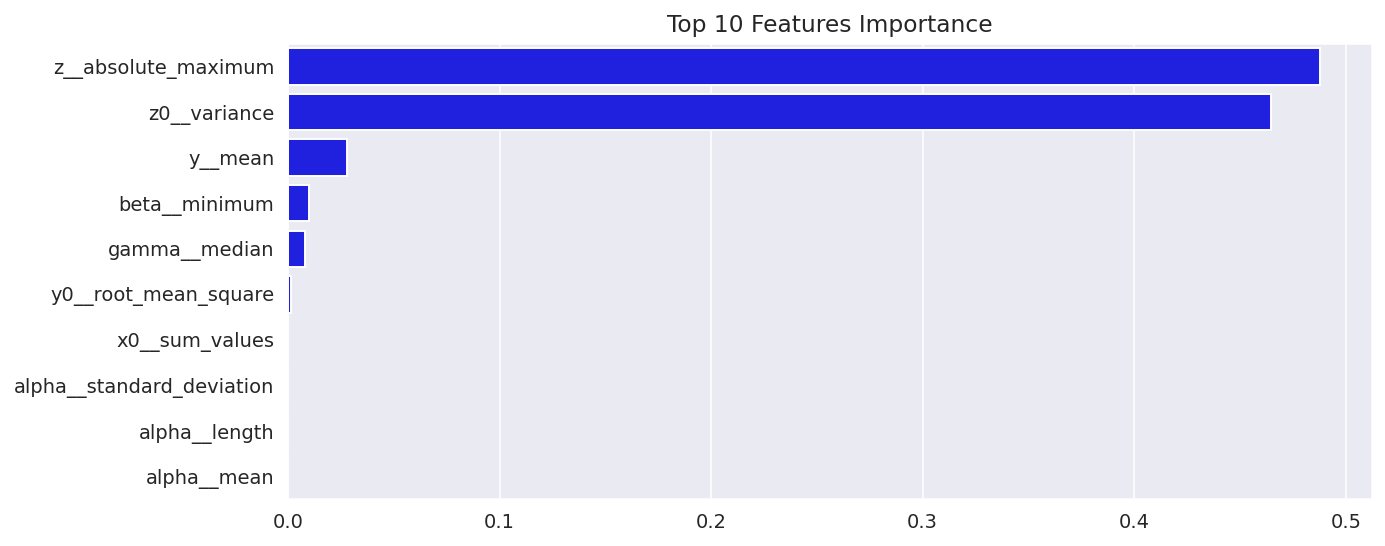

In [13]:
features_idx = (-clf.feature_importances_).argsort()[:10]
fig, ax = plt.subplots(figsize=(10, 4), dpi=140)
sns.barplot(x=clf.feature_importances_[features_idx], y=X_train.columns[features_idx], ax=ax, orient="h", color="b")
ax.set_title("Top 10 Features Importance")
fig.tight_layout()
plt.show()

### Select features with non-zero importance

In [14]:
selected_features = X_train.columns[features_idx][clf.feature_importances_[features_idx].astype(bool)].to_list()
selected_features

['z__absolute_maximum',
 'z0__variance',
 'y__mean',
 'beta__minimum',
 'gamma__median',
 'y0__root_mean_square']

In [15]:
classify("stratified_train_test", X_train[selected_features], y_train, X_test[selected_features], y_test).drop(
    columns="split_method"
).sort_values("accuracy", ascending=False)

,classifier,accuracy,precision,recall,f1
1,Linear SVM,0.961039,0.964692,0.961039,0.960698
3,Gaussian Process,0.961039,0.964692,0.961039,0.960698
6,Neural Net,0.961039,0.964692,0.961039,0.960698
7,AdaBoost,0.948052,0.948052,0.948052,0.948052
4,Decision Tree,0.935065,0.944614,0.935065,0.933866
5,Random Forest,0.922078,0.935436,0.922078,0.920165
8,Naive Bayes,0.922078,0.935436,0.922078,0.920165
9,Gradient Boosting,0.922078,0.935436,0.922078,0.920165
0,Nearest Neighbors,0.909091,0.920594,0.909091,0.909280
2,RBF SVM,0.896104,0.918568,0.896104,0.894502



# Recursive Feature Elimination

In [17]:
classifiers_names = ["Linear SVM", "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting"]

classifiers = [
    SVC(kernel="linear", random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
    AdaBoostClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
]

elimination_results = pd.DataFrame(columns=["classifier", "features", "accuracy"])

for name, clf in zip(classifiers_names, classifiers):
    selector = RFE(clf, n_features_to_select=len(selected_features))
    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_].to_list()
    clf.fit(X_train[selected_features], y_train)
    y_pred = clf.predict(X_test[selected_features])
    elimination_results.loc[len(elimination_results)] = [name, selected_features, accuracy_score(y_test, y_pred)]

elimination_results.sort_values("accuracy", ascending=False)

/home/dmitrii/anaconda3/envs/csapp/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/dmitrii/anaconda3/envs/csapp/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/dmitrii/anaconda3/envs/csapp/lib/python3.7/site-packages/sklearn/gaussian_process/_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  

,classifier,features,accuracy
1,Decision Tree,"[y0__root_mean_square, z0__standard_deviation,...",0.974026
0,Linear SVM,"[z0__absolute_maximum, z0__minimum, z__absolut...",0.948052
4,Gradient Boosting,"[z0__standard_deviation, z0__variance, x__root...",0.948052
2,Random Forest,"[z0__standard_deviation, x__root_mean_square, ...",0.935065
3,AdaBoost,"[x__root_mean_square, y__root_mean_square, z__...",0.857143


## Observations
1. The RFE algorithm provides a different set of features than the one we chose,
2. But the validation shows that the performance on this subset is better than when using our selected subset or all the features. (Best k features != k best features)

## Get the most frequently selected features

In [18]:
rfe_features = [j for i in elimination_results["features"].to_list() for j in i]
features_frequency = {x: rfe_features.count(x) for x in rfe_features}
features_frequency = dict(sorted(features_frequency.items(), key=lambda item: item[1], reverse=True))
features_frequency

{'z__minimum': 3,
 'z0__standard_deviation': 3,
 'x__root_mean_square': 3,
 'z__absolute_maximum': 2,
 'x__absolute_maximum': 2,
 'z__maximum': 2,
 'z__root_mean_square': 2,
 'z0__absolute_maximum': 1,
 'z0__minimum': 1,
 'beta__standard_deviation': 1,
 'gamma__root_mean_square': 1,
 'y0__root_mean_square': 1,
 'y__median': 1,
 'beta__variance': 1,
 'beta__root_mean_square': 1,
 'z__median': 1,
 'beta__minimum': 1,
 'y__root_mean_square': 1,
 'z0__variance': 1,
 'x__minimum': 1}

In [19]:
new_selected_features = elimination_results[elimination_results["classifier"] == "Decision Tree"]["features"].to_list()[
    0
]
new_selected_features

['y0__root_mean_square',
 'z0__standard_deviation',
 'y__median',
 'z__minimum',
 'beta__variance',
 'beta__root_mean_square']

In [20]:
new_data = data[new_selected_features + ["label"]]
new_data.to_csv("../data/clean_data.csv", index=False)

In [21]:
rfe_features = [j for i in elimination_results["features"].to_list() for j in i]
features_frequency = {x: rfe_features.count(x) for x in rfe_features}
features_frequency = dict(sorted(features_frequency.items(), key=lambda item: item[1], reverse=True))
features_frequency

{'z__minimum': 3,
 'z0__standard_deviation': 3,
 'x__root_mean_square': 3,
 'z__absolute_maximum': 2,
 'x__absolute_maximum': 2,
 'z__maximum': 2,
 'z__root_mean_square': 2,
 'z0__absolute_maximum': 1,
 'z0__minimum': 1,
 'beta__standard_deviation': 1,
 'gamma__root_mean_square': 1,
 'y0__root_mean_square': 1,
 'y__median': 1,
 'beta__variance': 1,
 'beta__root_mean_square': 1,
 'z__median': 1,
 'beta__minimum': 1,
 'y__root_mean_square': 1,
 'z0__variance': 1,
 'x__minimum': 1}

In [22]:
new_selected_features = elimination_results[elimination_results["classifier"] == "Decision Tree"]["features"].to_list()[
    0
]
new_selected_features

['y0__root_mean_square',
 'z0__standard_deviation',
 'y__median',
 'z__minimum',
 'beta__variance',
 'beta__root_mean_square']

## Save dataset with selected features

In [23]:
new_data = data[new_selected_features + ["label"]]
new_data.to_csv("../data/clean_data.csv", index=False)